In [294]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
import seaborn as sns


In [256]:
def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200):
    ds[[f'{driver_variable} day {n}' for n in range(numdays)]] = ds[[f'{driver_variable} day {n}' for n in range(numdays)]].cumsum(axis = 1)
    return ds

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)#.dropna()
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

In [ ]:
def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

In [295]:
ds

,level_0,year,Stations_Id,mingrad,maxgrad,minday,maxday,second last 75 percentile,last 75 percentile,tas day 0,...,tas day 199,lat,lon,WC SOS,observed time emergence to beginning of flowering,observed time emergence to yellow ripeness,emergence date,modelled time to emergence,modelled time to beginning of flowering,modelled time to yellow ripeness
0,1,2018,7521.0,103.0,161.0,130.0,184.0,165.0,212.0,8.156436,...,3077.010971,54.4333,9.8167,2018-04-15 12:00:00,63.0,108.0,136,31.0,79.0,112.0
1,2,2019,7521.0,180.0,289.0,249.0,134.0,109.0,159.0,5.500000,...,2825.385764,54.4333,9.8167,2019-04-15 12:00:00,89.0,147.0,120,50.0,97.0,136.0
2,3,2020,7521.0,172.0,227.0,206.0,121.0,103.0,148.0,4.700000,...,2787.779976,54.4333,9.8167,2020-04-14 12:00:00,91.0,166.0,120,58.0,107.0,149.0
3,4,2021,7521.0,297.0,178.0,155.0,234.0,262.0,265.0,4.643565,...,2815.555254,54.4333,9.8167,2021-04-15 12:00:00,81.0,141.0,130,55.0,91.0,142.0
4,5,2022,7521.0,212.0,139.0,106.0,287.0,208.0,269.0,7.239809,...,2878.053744,54.4333,9.8167,2022-04-15 12:00:00,75.0,122.0,128,52.0,98.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3926,6844,2017,19914.0,135.0,165.0,154.0,254.0,243.0,270.0,5.797429,...,2944.024003,50.3168,9.3627,2017-04-16 12:00:00,57.0,NaN,135,38.0,71.0,110.0
3927,6845,2018,19914.0,141.0,97.0,248.0,125.0,201.0,317.0,14.501710,...,3345.472815,50.3168,9.3627,2018-04-16 12:00:00,71.0,NaN,129,20.0,55.0,93.0
3928,6846,2019,19914.0,95.0,158.0,240.0,181.0,158.0,205.0,11.205063,...,3092.934249,50.3168,9.3627,2019-04-16 12:00:00,64.0,NaN,134,40.0,73.0,107.0
3929,6849,2022,19914.0,186.0,91.0,234.0,143.0,109.0,161.0,9.142498,...,3270.678910,50.3168,9.3627,2022-04-16 12:00:00,57.0,NaN,136,30.0,70.0,101.0


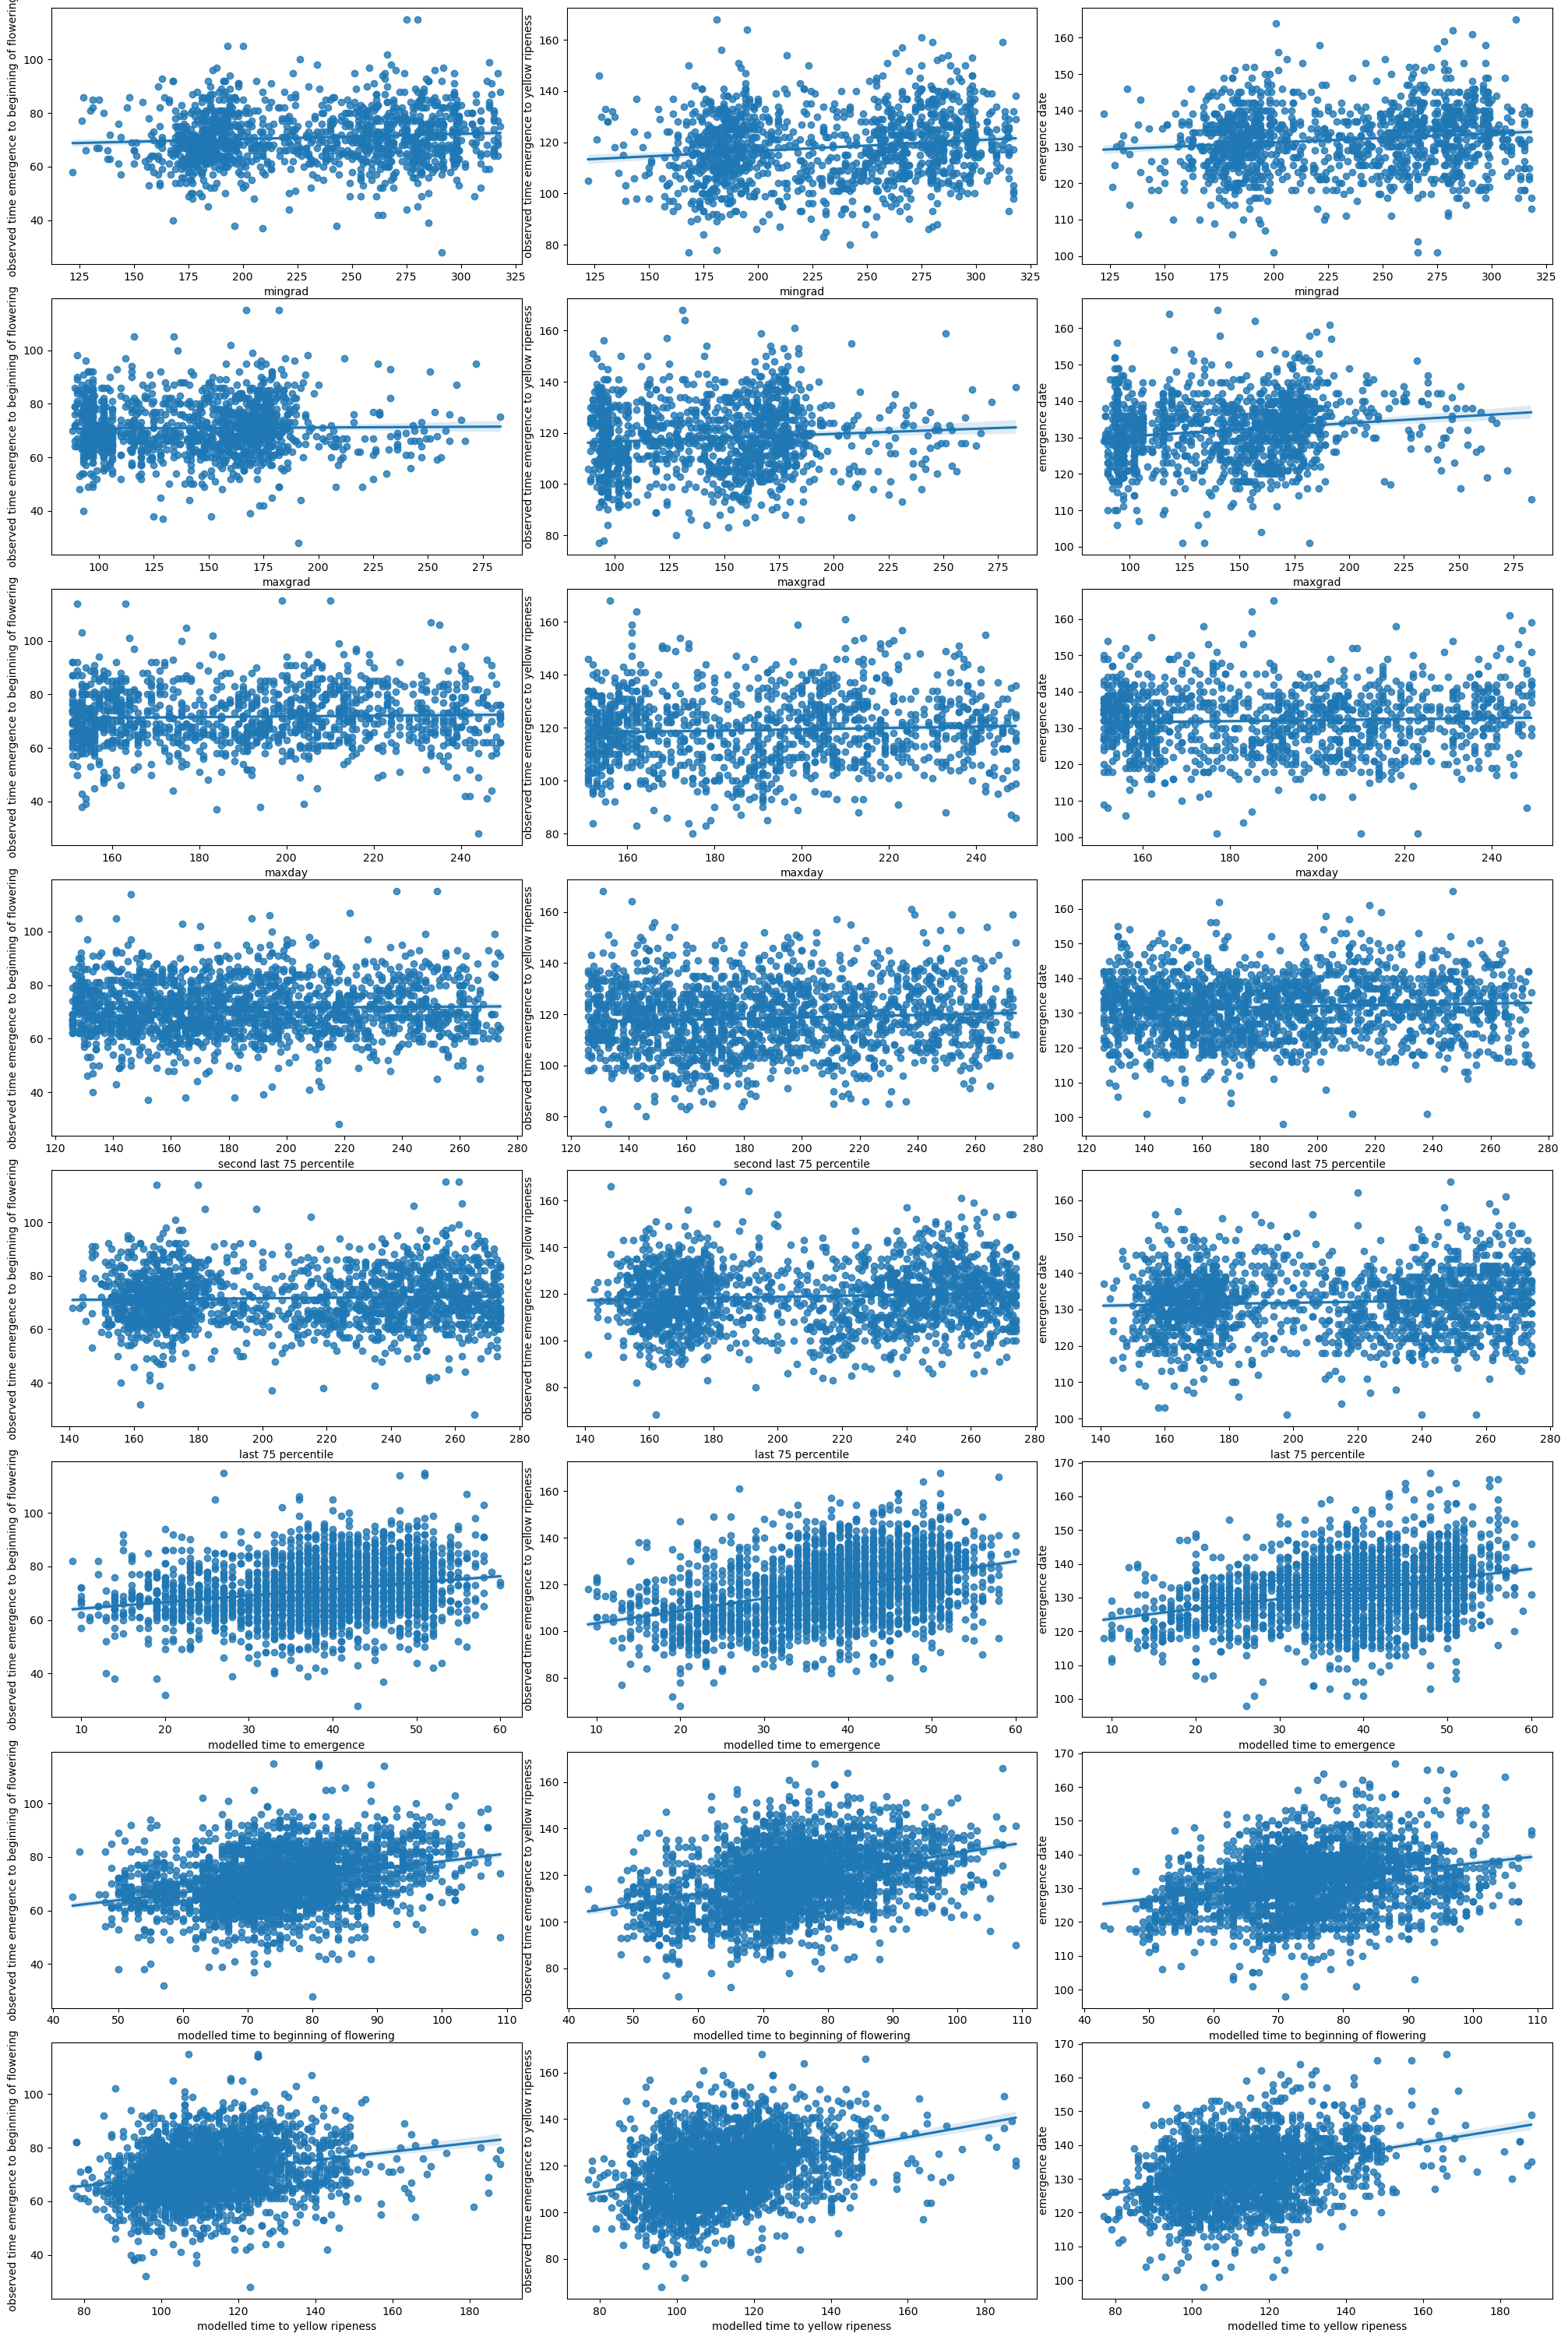

In [301]:
fig, axes = plt.subplots(8, 3, figsize = (20, 30))
fig.tight_layout()
predictors = ['mingrad', 'maxgrad', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'modelled time to emergence', 'modelled time to beginning of flowering', 'modelled time to yellow ripeness']
observed_variables = ['observed time emergence to beginning of flowering', 'observed time emergence to yellow ripeness', 'emergence date']
for observed_variable in observed_variables:
    ds = ds.where((ds[observed_variable] < 250)*(ds[observed_variable] > 10))
for predictor_index, predictor in enumerate(predictors):
    for observed_variable_index, observed_variable in enumerate(observed_variables):
        if predictor == 'mingrad' or predictor == 'maxgrad':
            ds_no_outliers = ds.where(ds['mingrad'] > ds['maxgrad']).dropna(how='all')
        elif predictor == 'maxday':
            ds_no_outliers = ds.where((ds[predictor] < 250)*(ds[predictor] > 150)).dropna(how='all')
        elif predictor == 'second last 75 percentile' or predictor == 'last 75 percentile':
            ds_no_outliers = ds.where((ds[predictor] < 275)*(ds[predictor] > 125)).dropna(how='all')
        elif predictor == 'modelled time to emergence' or predictor == 'modelled time to beginning of flowering' or predictor == 'modelled time to yellow ripeness':
            ds_no_outliers = ds.where(ds[predictor] < 200).dropna(how='all')
        else:
            ds_no_outliers = ds
        sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axes[predictor_index, observed_variable_index])

In [250]:
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times.csv')
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time emergence to beginning of flowering', 'emergence date'])
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 'tas', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear

In [278]:
thinning_num = 20
training_columns = ['modelled time to emergence', 'modelled time to beginning of flowering'] #+ ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile'] #[f'tas day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + 
response_columns = ['observed time emergence to beginning of flowering', 'emergence date']#['observed time emergence to beginning of flowering', 'observed time emergence to yellow ripeness', 'emergence date']#['observed time emergence to yellow ripeness']#
training, verification = subsample(ds, subsample_frac = 0.9)

In [289]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth = 3,
                             min_samples_leaf=2)
X_training = training[training_columns].values
y_training = training[response_columns].values
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values
clf_fit = clf.fit(X_training, y_training)

In [290]:
ds_results.where(ds_results['verification'] == 'training').dropna(how = 'all')['modelled time to emergence'].dropna()#['RF to beginning of flowering']

587     139.0
347     154.0
1336    306.0
675     154.0
3566    129.0
        ...  
1331    136.0
1219    133.0
1215    132.0
2676    139.0
606     135.0
Name: modelled time to emergence, Length: 3533, dtype: float64

In [291]:
len(ds_results)/7

561.5714285714286

In [292]:
phase_list = ['beginning of flowering', 'emergence']#['beginning of flowering', 'yellow ripeness', 'emergence']
for phase_index, phase in enumerate(phase_list):
    training.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)[:, phase_index]
    verification.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)[:, phase_index]
    training[f'ML check obs to {phase}'] = y_training[:, phase_index]
    verification[f'ML check obs to {phase}'] = y_eval[:, phase_index]
verification['verification'] = 'verification'
training['verification'] = 'training'
ds_results = pd.concat([verification, training], axis=0)
ds_results['modelled time to emergence'] = ds_results['modelled time to emergence'] + pd.to_datetime(ds_results['WC SOS']).dt.dayofyear
ds_results['modelled time to emergence']
ds_results = ds_results.rename(columns = {'observed time emergence to beginning of flowering': 'observed time to beginning of flowering', 
                                          'observed time emergence to yellow ripeness': 'observed time to yellow ripeness'})
ds_results['observed time to emergence'] = ds_results['emergence date']
r2_modelled_observed(ds_results.where(ds_results['verification'] == 'verification').dropna(how = 'all').dropna(subset=['modelled time to emergence']), ['emergence', 'beginning of flowering'])#, 'yellow ripeness'



emergence

modelled time emergence to emergence, R2 score: -6.34862553423571 
ML prediction emergence to emergence, R2 score: 0.08474917612438548

beginning of flowering

modelled time emergence to beginning of flowering, R2 score: -2.6901253226636213 
ML prediction emergence to beginning of flowering, R2 score: -0.011653982906634663


In [258]:
len(training_columns)

16

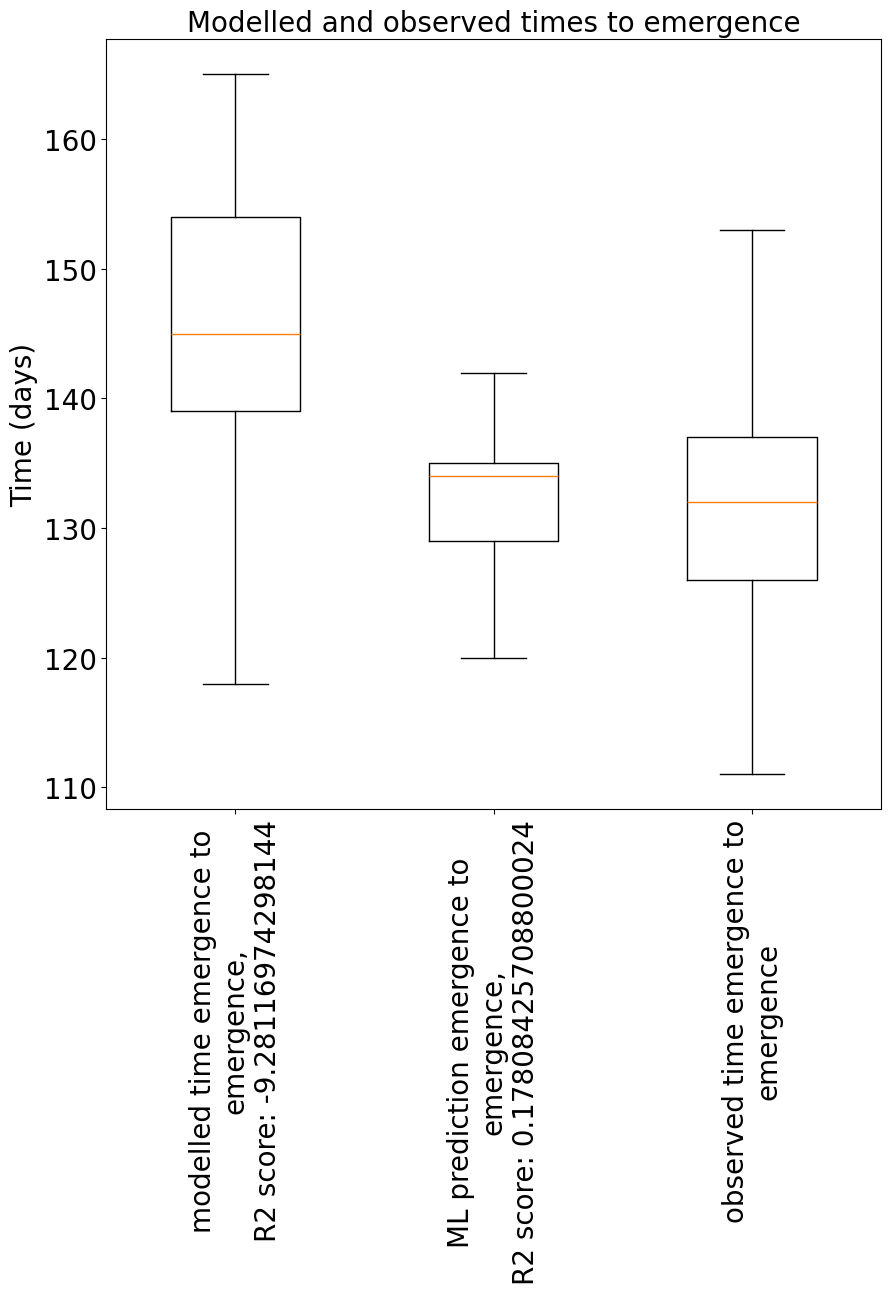

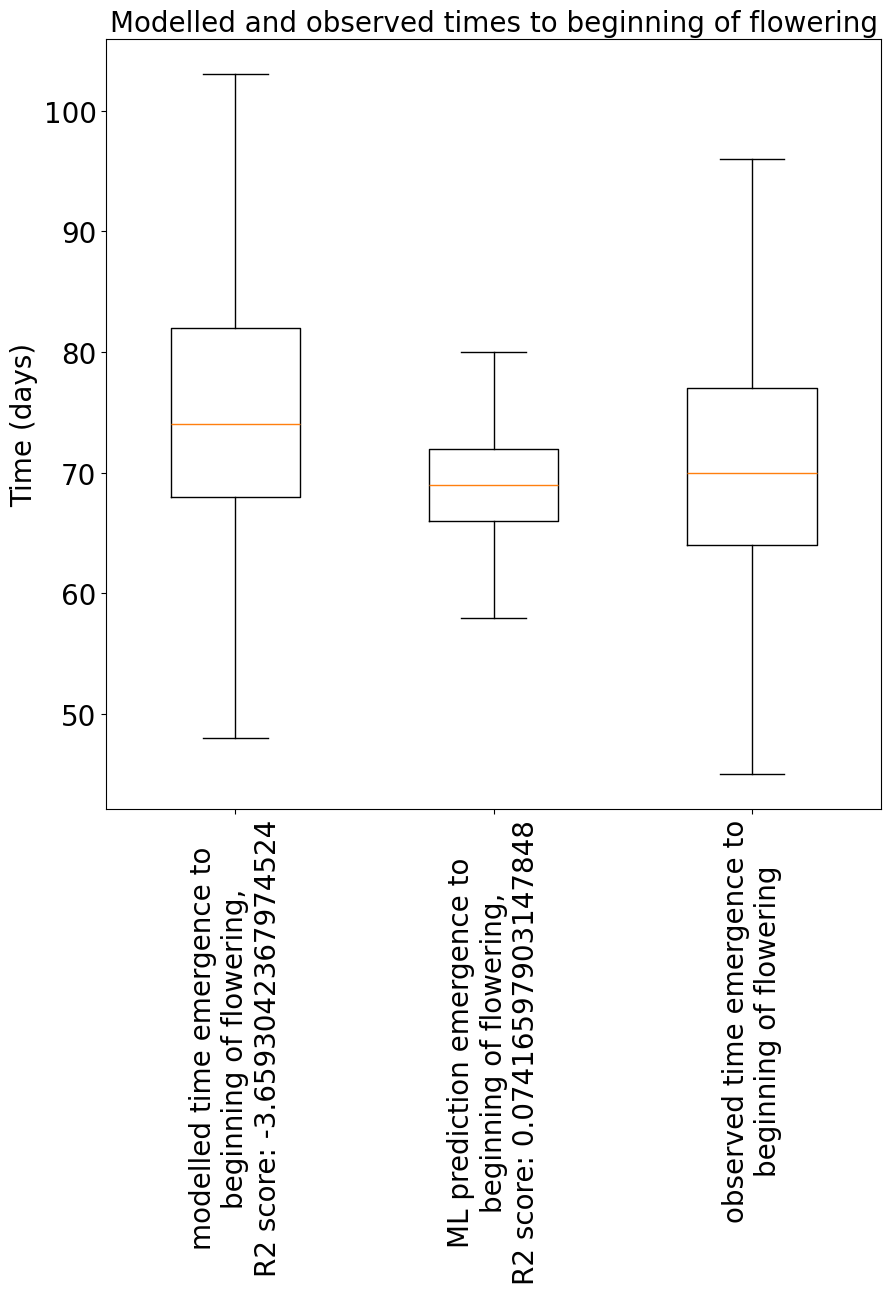

In [264]:
box_plot_modelled_observed(ds_results.where(ds_results['verification'] == 'verification').dropna(how = 'all').dropna(subset=['modelled time to emergence']), ['emergence', 'beginning of flowering']) #, 'yellow ripeness'

In [196]:
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values

r = permutation_importance(clf_fit, X_eval, y_eval,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{training_columns[i]:<15}",
            f"{r.importances_mean[i]:.3f}",
            f" +/- {r.importances_std[i]:.3f}")

ValueError: multiclass-multioutput is not supported